this notebook is prepared by kevin zhu for SYDE 522.

references used:
- CS 684
- https://www.cs.rice.edu/~vo9/vision/slides/lecture08-RANSAC.pdf
- https://scikit-image.org/docs/stable/auto_examples/transform/plot_ransac.html#sphx-glr-auto-examples-transform-plot-ransac-py

# Line Fitting

### Part 1: Least-squares

In [1]:
import math
import numpy as np

from skimage.measure import ransac

import matplotlib.pyplot as plt
%matplotlib inline

Let's generate some fake 2D data...

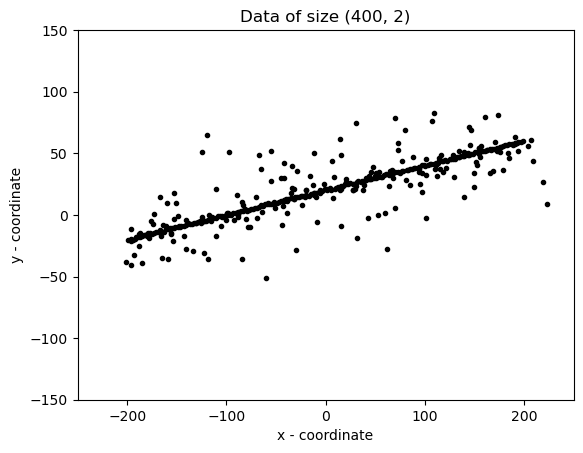

In [2]:
np.random.seed(seed=1)

# parameters for "true" line y = a*x + b
a, b = 0.2, 20.0

# x-range of points [x1,x2]
x_start, x_end = -200.0, 200.0

# generate the "true" line points
x = np.arange(x_start,x_end)
y = a * x + b               
data = np.column_stack([x, y])    # staking data points into (Nx2) array

# add some noise around line
noise = np.random.normal(size=data.shape) # generating Gaussian noise (variance 1) for each data point (rows in 'data')
data += 0.5 * noise
data[::2] += 5 * noise[::2]  # every second point adds noise with variance 5
data[::4] += 20 * noise[::4] # every fourth point adds noise with variance 20

#-----------------------------------------------------------------------------
# plot
fig, ax = plt.subplots()
ax.plot(data[:,0], data[:,1], '.k')
ax.set_xlim(-250,250)
ax.set_ylim(-150,150)
ax.set_xlabel('x - coordinate')
ax.set_ylabel('y - coordinate')
plt.title('Data of size {}'.format(data.shape))
plt.show()


Complete implementation of function `estimate` of class `LeastSquareLine` below. It should update line parameters $a$ and $b$ correpsonding to line model $y=ax+b$. 

In [14]:
class LeastSquareLine:
    def __init__(self):
        # line parameters
        self.a = 0.0
        self.b = 0.0

    def estimate(self, points2D):
        x_coords = points2D[:, 0]
        y_coords = points2D[:, 1]

        x_mean = np.mean(x_coords)
        y_mean = np.mean(y_coords)

        self.a = np.sum((x_coords - x_mean) * (y_coords - y_mean)) / np.sum((x_coords - x_mean)**2)
        self.b = y_mean - self.a * x_mean

    def predict(self, x):
        return (self.a * x) + self.b

    def residuals(self, points2D):
        return points2D[:,1] - self.predict(points2D[:,0])

    def line_params(self):
        return self.a, self.b

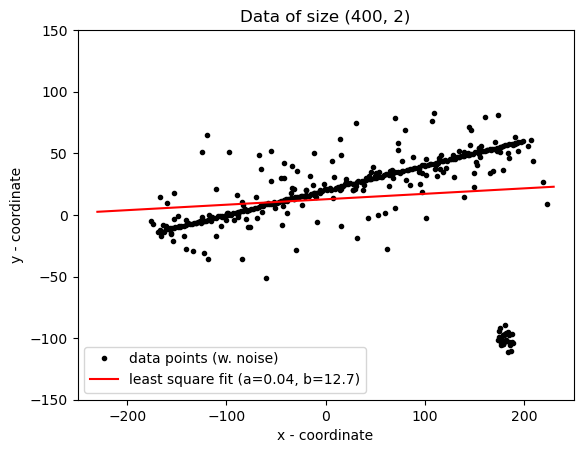

In [15]:
LSline = LeastSquareLine() # use our Least Squares implementation
LSline.estimate(data) #fit Least squares on data

a_ls, b_ls = LSline.line_params()

#-----------------------------------------------------------------------------
# plot
fig, ax = plt.subplots()
ends = np.array([x_start-30,x_end+30])
ax.plot(data[:,0], data[:,1], '.k', label='data points (w. noise)')
ax.plot(ends, LSline.predict(ends), '-r', label='least square fit (a={:4.2f}, b={:4.1f})'.format(a_ls,b_ls))
ax.set_xlim(-250,250)
ax.set_ylim(-150,150)
ax.set_xlabel('x - coordinate')
ax.set_ylabel('y - coordinate')
ax.legend(loc='lower left')
plt.title('Data of size {}'.format(data.shape))
plt.show()

What if outliers exist?

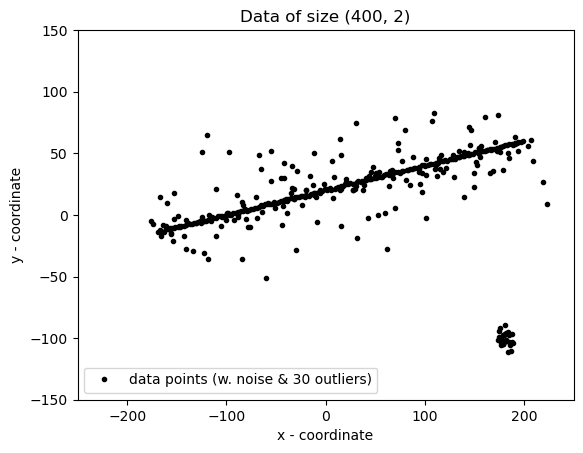

In [16]:
# making some points outliers
np.random.seed(seed=1)
faulty = np.array(30 * [(180., -100)])  # (30x2) array containing 30 rows [180,-100]  (points)
faulty += 5 * np.random.normal(size=faulty.shape)  # adding Gaussian noise to these points
data[:faulty.shape[0]] = faulty   # replacing the first 30 points in data with faulty (outliers)

#-----------------------------------------------------------------------------
# plot
fig, ax = plt.subplots()
ax.plot(data[:,0], data[:,1], '.k', label='data points (w. noise & 30 outliers)')
ax.set_xlim(-250,250)
ax.set_ylim(-150,150)
ax.set_xlabel('x - coordinate')
ax.set_ylabel('y - coordinate')
ax.legend(loc='lower left')
plt.title('Data of size {}'.format(data.shape))
plt.show()


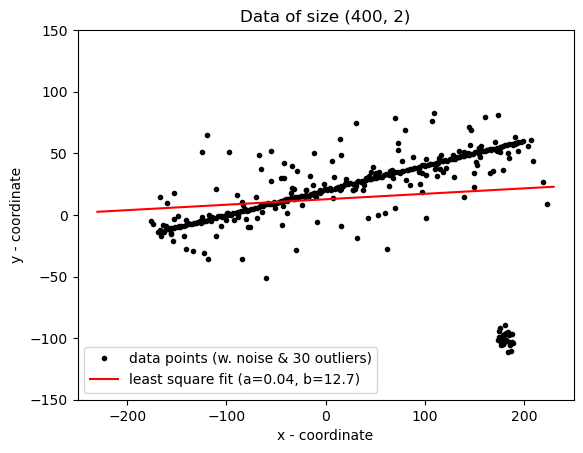

In [17]:
LSline = LeastSquareLine() # use our Least Squares implementation
LSline.estimate(data) #fit Least squares on data

a_ls, b_ls = LSline.line_params()

#-----------------------------------------------------------------------------
# plot
fig, ax = plt.subplots()
ax.plot(data[:,0], data[:,1], '.k', label='data points (w. noise & 30 outliers)')
ax.plot(ends, LSline.predict(ends), '-r', label='least square fit (a={:4.2f}, b={:4.1f})'.format(a_ls,b_ls))
ax.set_xlim(-250,250)
ax.set_ylim(-150,150)
ax.set_xlabel('x - coordinate')
ax.set_ylabel('y - coordinate')
ax.legend(loc='lower left')
plt.title('Data of size {}'.format(data.shape))
plt.show()

### Part 2: RANdom SAmple Consensus (RANSAC)

<div>
<img src="ransac.gif" width="700"/>
</div>

2.1 Assume that a 2D dataset of $N=100$ points includes $N_i=20$ inliers and $N_o=80$ outliers. 

What is the least number of times one should sample a random pair of points ($s=2$) from the set to get probability $p\geq 0.95$ that in at least one of the sampled pairs, all points are inliers? 

Derive a general formula and compute a numerical answer for the specified numbers.

In [20]:
""" 
Compute number of trials needed for RANSAC.

Args:
    p (float): probability that at least one sample contain all inliers.
    s (int): size of each sample.
    N_i (int): number of inliers.
    N_o (int): number of outliers.

Returns:
    T (int) number of trials needed.
"""

def iterations(p, s, N_i, N_o):
    # your code here.
    p_i = N_i/(N_i + N_o) # probability of selecting an inlier
    T = (np.log(1-p) / np.log(1 - p_i**s))
    return math.ceil(T)

T = iterations(0.95, 2, 20, 80)
print('Number of trials:', T)

Number of trials: 74


2.2 Using the knowledge of the number of inliers/outliers, estimate the minimum number of sampled pairs needed to get RANSAC to "succeed" (to get at least one pair of inliers) with $p\geq 0.95$. 

Use your formula in 2.1. Show your numbers in the cell below. Then, use your estimate of $T$ as a value of parameter `max_trials` inside function `ransac` in the code cell below. You should also change `residual_threshold` according to the noise level for inliers in the example. 

Number of trials: 2


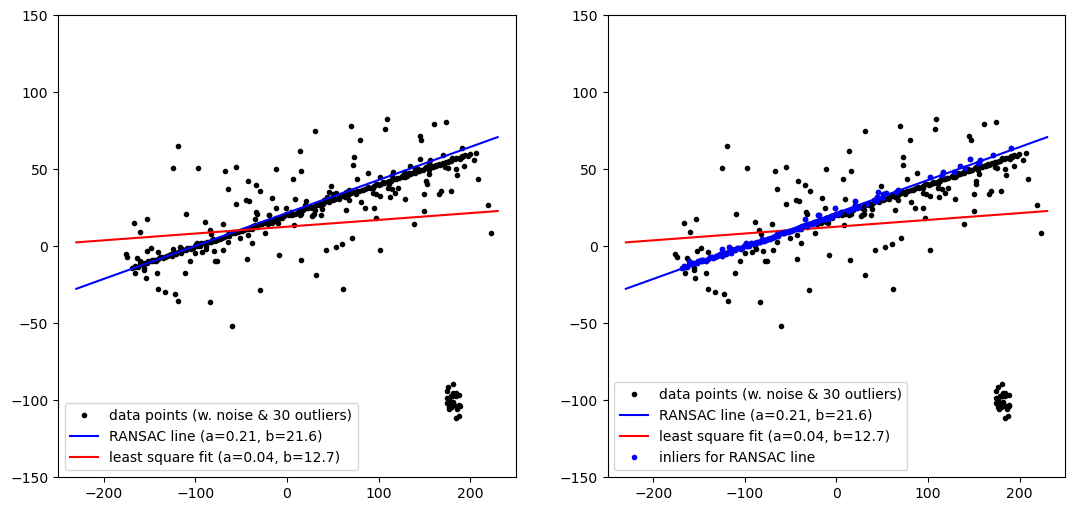

In [21]:
N_o = 30 # number of outliers
N_i = len(data) - N_o # number of inliers
T = iterations(0.95, 2, N_i, N_o) # number of trials needed
print('Number of trials:', T)

# fit data using RANSAC algorithm
ransacfit, inliers = ransac(data, LeastSquareLine, min_samples = 2, residual_threshold = 3, max_trials = T)
a_ransac, b_ransac = ransacfit.line_params()
#print('a:', a_ransac, 'b:', b_ransac)

#-----------------------------------------------------------------------------
# plot
plt.figure(2,figsize = (13,6))
for i in range(2):
    ax = plt.subplot(121+i)
    ax.plot(data[:,0], data[:,1], '.k', label='data points (w. noise & 30 outliers)')
    ax.plot(ends, ransacfit.predict(ends), '-b', label='RANSAC line (a={:4.2f}, b={:4.1f})'.format(a_ransac,b_ransac))
    ax.plot(ends, LSline.predict(ends), '-r', label='least square fit (a={:4.2f}, b={:4.1f})'.format(a_ls,b_ls))
    ax.set_xlim(-250,250)
    ax.set_ylim(-150,150)
    ax.legend(loc='lower left')
ax.plot(data[inliers, 0], data[inliers, 1], '.b', alpha=1, label='inliers for RANSAC line')
ax.legend(loc='lower left')

plt.show()

### Part 3: sequential RANSAC

What if muliple lines exist?

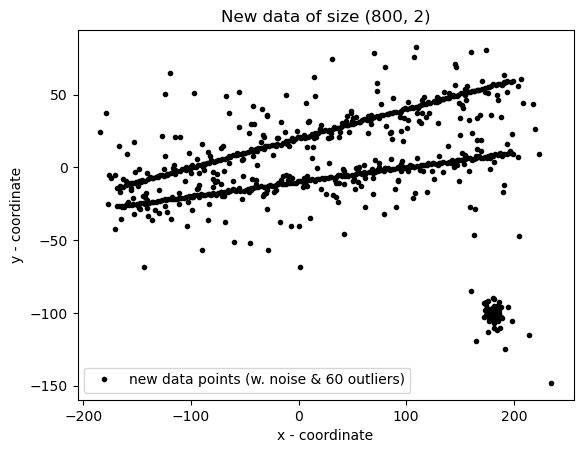

In [22]:
# add another line with noise

# parameters for "true" lines y = a*x + b
a2, b2 = 0.1, -10.0

# generate the "true" line points
y2 = a2 * x + b2
data2 = np.column_stack([x, y2])    # staking data points into (Nx2) array

# add faulty data (i.e. outliers)
faulty = np.array(30 * [(180., -100)])  # (30x2) array containing 30 rows [180,-100]  (points)
faulty += 5 * np.random.normal(size=faulty.shape)  # adding Gaussian noise to these points
data2[:faulty.shape[0]] = faulty   # replacing the first 30 points in data2 with faulty (outliers)

# add gaussian noise to coordinates
noise = np.random.normal(size=data.shape) # generating Gaussian noise (variance 1) for each data point (rows in 'data')
data2+= 0.5 * noise
data2[::2] += 5 * noise[::2]  # every second point adds noise with variance 5
data2[::4] += 20 * noise[::4] # every fourth point adds noise with variance 20

newdata = np.concatenate((data,data2)) # combining with previous data

#-----------------------------------------------------------------------------
# plot
fig, ax = plt.subplots()
ax.plot(newdata[:,0], newdata[:,1], '.k', label='new data points (w. noise & 60 outliers)')
ax.set_xlabel('x - coordinate')
ax.set_ylabel('y - coordinate')
ax.legend(loc='lower left')
plt.title('New data of size {}'.format(newdata.shape))
plt.show()

Number of trials: 13


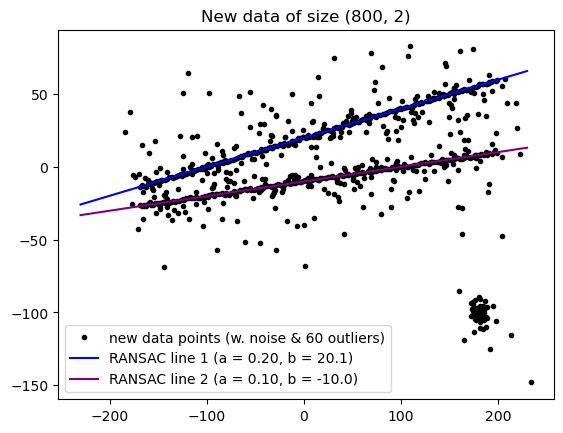

In [24]:
N_i = (len(newdata) - 60) / 2 # for each line, half of points that are not outliers are inliers
N_o = len(newdata) - N_i # rest are outliers (for each line)

# compute number of trials needed
T = iterations(0.95, 2, N_i, N_o) 
print('Number of trials:', T)

# fit first line using ransac
ransacfit1, inliers1 = ransac(newdata, LeastSquareLine, min_samples = 2, residual_threshold = 3, max_trials = T)
a_ransac1, b_ransac1 = ransacfit1.line_params()

# remaining points (that are not inliers for line 1)
newdata_r = newdata[~inliers1]

# fit second line using ransac on remaining points
ransacfit2, inliers2 = ransac(newdata_r, LeastSquareLine, min_samples = 2, residual_threshold = 3, max_trials =T)
a_ransac2, b_ransac2 = ransacfit2.line_params()

#-----------------------------------------------------------------------------
# plot
fig, ax = plt.subplots()
ax.plot(newdata[:,0], newdata[:,1], '.k', label='new data points (w. noise & 60 outliers)')
ax.plot(ends, ransacfit1.predict(ends), '-b', label = 'RANSAC line 1 (a = {:4.2f}, b = {:4.1f})'.format(a_ransac1, b_ransac1))
ax.plot(ends, ransacfit2.predict(ends), c='purple', label = 'RANSAC line 2 (a = {:4.2f}, b = {:4.1f})'.format(a_ransac2, b_ransac2))
ax.legend(loc = 'lower left')
plt.title('New data of size {}'.format(newdata.shape))
plt.show()